# Descan + STEM Overfocus procedure

Suppose we want to calibriate and verify the experimental microscope parameters of a fourdstem dataset which suffers from descan error - 

This notebook shows that using three reference datasets, taken at three *known* camera lengths (e.g. calibrated with polycrystalline gold diffraction rings), one can characterise the descan error matrix of the scan system of the microscope. 

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import copy
import jax.numpy as jnp
import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.udf.com import CoMUDF, RegressionOptions
from libertem.udf.masks import ApplyMasksUDF
from skimage.measure import label, regionprops
from concurrent.futures import ProcessPoolExecutor

In [3]:
from microscope_calibration.model import ModelParameters, DescannerErrorParameters, create_stem_model
from microscope_calibration.generate import generate_dataset_from_image
from microscope_calibration.interactive import interactive_window
from microscope_calibration.fitting import fit_descan_error_matrix
from microscope_calibration.stemoverfocus import project_coordinates_backward, inplace_sum, check_diameter_on_scan_and_det

from microscope_calibration.udf import ShiftedSumUDF
from jaxgym.utils import smiley

In [4]:
ctx = lt.Context.make_with("inline")

This notebook assumes you know the *pixel size* of your detector, and have acquired three overfocus dataset acquired at a *known camera lengths*, calibrated using some other method.

To begin we will generate this data so that this notebook is standalone.

## 0 - Generate data

In [5]:
sample_image = smiley(206)

In [6]:
# Create a random descan error matrix
s = 50000
descan_error = DescannerErrorParameters(
        pxo_pxi=np.random.uniform(-s, s),  # How position x output scales with respect to scan x position
        pxo_pyi=np.random.uniform(-s, s),  # How position x output scales with respect to scan y position 
        pyo_pxi=np.random.uniform(-s, s),  # How position y output scales with respect to scan x position
        pyo_pyi=np.random.uniform(-s, s),  # How position y output scales with respect to scan y position
        sxo_pxi=np.random.uniform(-s, s),  # How slope x output scales with respect to scan x position
        sxo_pyi=np.random.uniform(-s, s),  # How slope x output scales with respect to scan y position
        syo_pxi=np.random.uniform(-s, s),  # How slope y output scales with respect to scan x position
        syo_pyi=np.random.uniform(-s, s),  # How slope y output scales with respect to scan y position
        offpxi=np.random.uniform(-0.0, 0.0),  # Constant additive error in x position
        offsxi=np.random.uniform(-0.0, 0.0),  # Constant additive error in y position
        offpyi=np.random.uniform(-0.0, 0.0),  # Constant additive error in x slope
        offsyi=np.random.uniform(-0.0, 0.0)  # Constant additive error in y slope
    )

descan_error = DescannerErrorParameters(*descan_error)

params = ModelParameters(
    semi_conv=0.001,
    defocus=0.00001,  # Distance from the crossover to the sample
    camera_length=1.0,  # Distance from the point source to the detector
    scan_shape=(49, 49),  # YX!
    det_shape=(64, 64),  # YX!
    scan_step=(1e-9, 1e-9),  # YX!
    det_px_size=(1e-4, 1e-4),  # YX!
    scan_rotation=33.,
    descan_error=descan_error,
    flip_y=False,
)

In [7]:
datasets = {}
clengths = (0.5, 1.0, 1.5)


with ProcessPoolExecutor(max_workers=3) as p:
    futures = []
    for cl in clengths:
        _params = copy.deepcopy(params)
        _params["camera_length"] = cl
        f = p.submit(generate_dataset_from_image, _params, sample_image, method="linear", progress=False)
        futures.append(f)
    
    for f, cl in zip(futures, clengths):
        data = f.result()
        datasets[cl] = ctx.load("memory", data=data, num_partitions=1)

## 1 - Determine approximate semiconvergence angle

We can determine an approximate $\alpha$ by measuring the radius of the transmitted beam in pixels, and using the pixel size and camera length to measure the angle of the triangle with origin at the point source.

In [8]:
guesses = []
for cl in datasets.keys():
    det_px_size = min(params["det_px_size"])
    sy, sx = datasets[cl].shape.nav
    pick_a = ctx.create_pick_analysis(datasets[cl], sx // 2, sy // 2)
    frame = ctx.run(pick_a).intensity.raw_data
    radius = (
        max(
            regionprops(label(frame > frame.max() * 0.5)), key=lambda r: r.area
        ).equivalent_diameter
        / 2
    )
    semi_conv_guess = float(np.atan2(radius * det_px_size, cl)) # Still in small angle approximation, so atan2 should make no difference.
    guesses.append(semi_conv_guess)
    print(f"Camera length: {cl}, Approximate semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

semi_conv_guess = np.mean(guesses)
print(f"Average approximte semiconv: {semi_conv_guess:.3f}, True value {params['semi_conv']}")

Camera length: 0.5, Approximate semiconv: 0.001, True value 0.001
Camera length: 1.0, Approximate semiconv: 0.001, True value 0.001
Camera length: 1.5, Approximate semiconv: 0.001, True value 0.001
Average approximte semiconv: 0.001, True value 0.001


## 1.5 - Determine approximate semiconvergence angle

Visualise images of the detector with descan error, and their backprojection onto the scan grid. 

NumbaValueError: unsupported PEP 3118 format '=i'

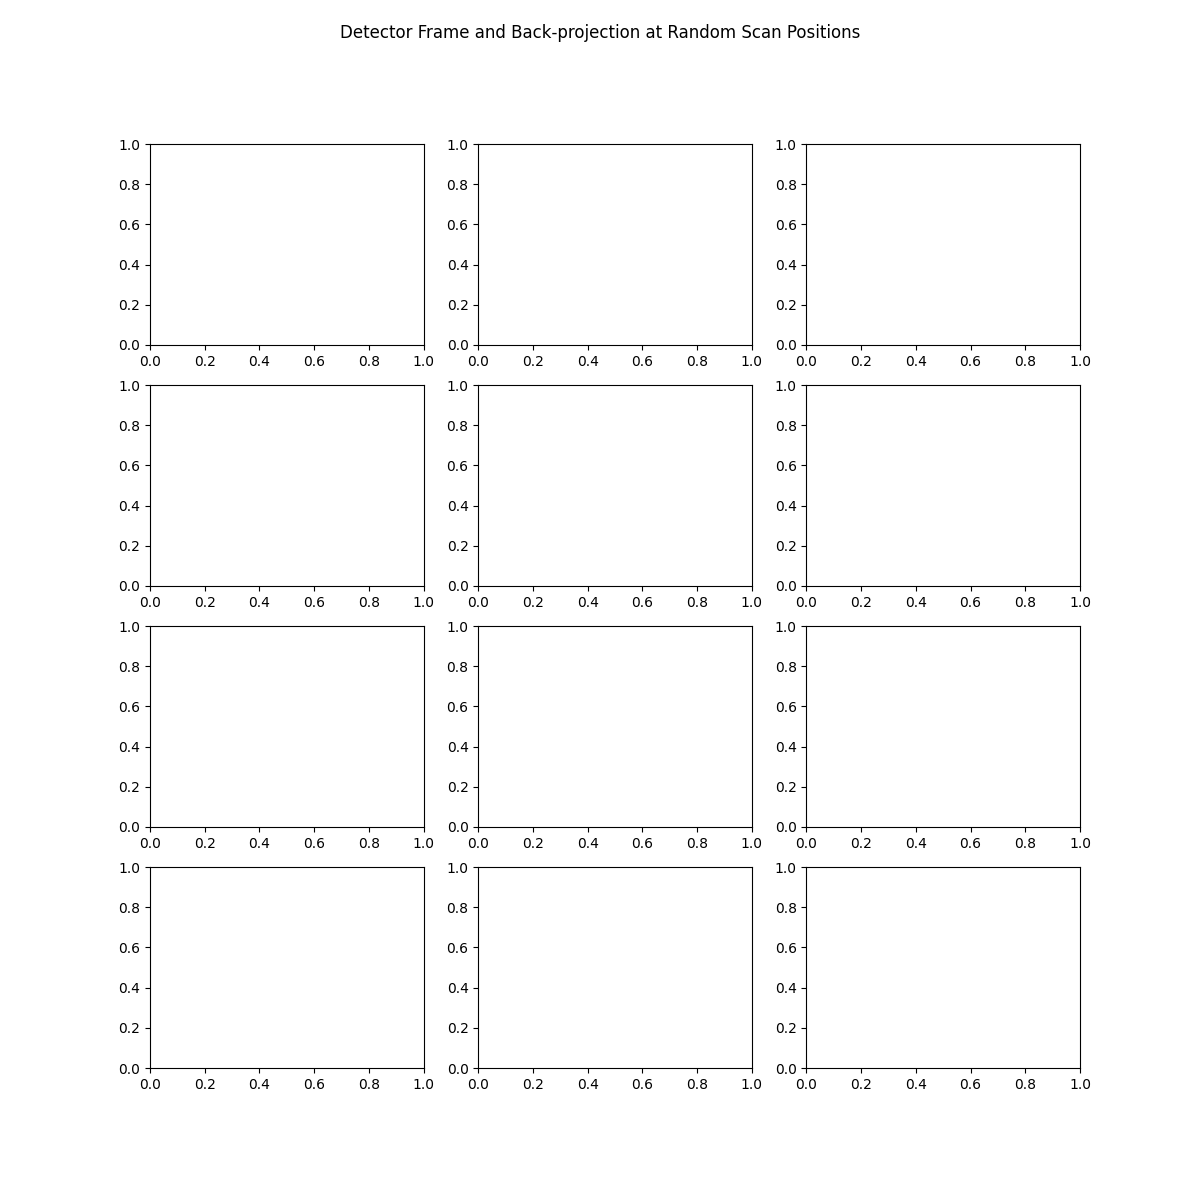

In [ ]:
params_wrong_descan = copy.deepcopy(params)
params_wrong_descan['descan_error'] = DescannerErrorParameters()
model_wrong_descan = create_stem_model(params_wrong_descan)
model_right_descan = create_stem_model(params)
PointSource, ScanGrid, Descanner, Detector = model_right_descan
det_coords = Detector.get_coords()
scan_coords = ScanGrid.get_coords()

cl = 1.0

ds = datasets[cl]
sy, sx = ds.shape.nav

# pick 4 random scan positions
idxs = np.random.choice(len(scan_coords), 4, replace=False)

fig, axs = plt.subplots(4, 3, figsize=(12, 12))
fig.suptitle('Detector Frame and Back-projection at Random Scan Positions')

for ax_row, idx in zip(axs, idxs):
    # get scan coordinate and nav indices
    scan_pos = scan_coords[idx]
    iy, ix = divmod(int(idx), sx)

    # detector frame at that scan position
    pick_a = ctx.create_pick_analysis(ds, ix, iy)
    det_frame = ctx.run(pick_a).intensity.raw_data

    # back-projection with wrong descan error
    px_y, px_x, mask = project_coordinates_backward(model_wrong_descan, det_coords, scan_pos)
    scan_img_wrong = np.zeros(ds.shape.nav)
    inplace_sum(np.array(px_y), np.array(px_x), np.array(mask), det_frame.ravel(), scan_img_wrong)

    # back-projection with correct descan error
    px_y, px_x, mask = project_coordinates_backward(model_right_descan, det_coords, scan_pos)
    scan_img_right = np.zeros(ds.shape.nav)
    inplace_sum(np.array(px_y), np.array(px_x), np.array(mask), det_frame.ravel(), scan_img_right)

    # plot: detector, wrong back-proj, correct back-proj
    ax_row[0].imshow(det_frame, cmap='gray')
    ax_row[0].set_title(f'Detector @ ({iy}, {ix})')

    ax_row[1].imshow(scan_img_wrong, cmap='gray')
    ax_row[1].set_title(f'Back-proj wrong @ ({iy}, {ix})')

    ax_row[2].imshow(scan_img_right, cmap='gray')
    ax_row[2].set_title(f'Back-proj correct @ ({iy}, {ix})')

plt.tight_layout()


One can clearly see that the disks on the detector do not land in the centre as a result of descan error. And one can also see with an unknown descan error matrix, the backprojection to the scan grid is distorted. 

## 2 - Visualise descan error

For a better visualisation, we start with a sum image of all dataset frames, and the CoM shift magnitude relative to the frame centre for each scan position:

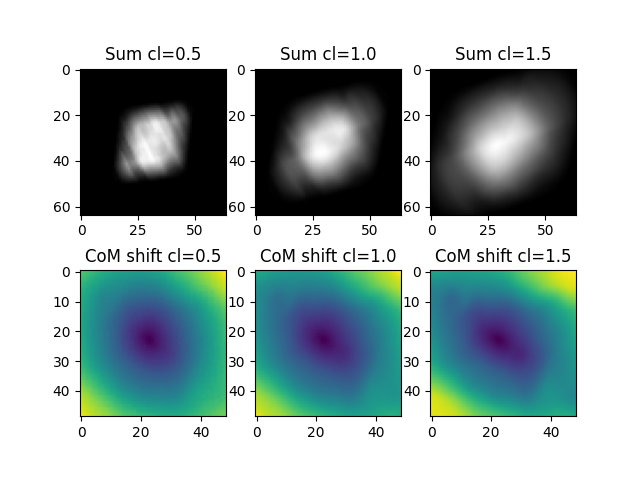

In [10]:
fig, axs = plt.subplots(2, 3)

px_shifts_matrix = {}
shifts = {}
distances = {}

com_r = {}
com_udf = CoMUDF.with_params()
for i, (cl, ds) in enumerate(datasets.items()):
    sum_res, com_res = ctx.run_udf(ds, [SumUDF(), com_udf])
    com_r[cl] = com_res
    axs[0, i].imshow(sum_res["intensity"].data, cmap="gray")
    axs[0, i].set_title(f"Sum cl={cl}")
    
for i, (cl, ds) in enumerate(datasets.items()):
    axs[1, i].imshow(com_r[cl]["magnitude"].data)
    axs[1, i].set_title(f"CoM shift cl={cl}")

We can see that there is more descan error at longer camera lengths, meaning we have an error dependent on the slope of the rays leaving the descanner.

## 3 - Determine parameters with per dataset descan adjustment via LiberTem COM analysis

Even in the presence of descan error, we can reconstruct a single dataset to determine the scan geometry and defocus. We can use LiberTem's com analysis to determine a specific transfer matrix for each dataset to shift the disks to the centre. This shift must be recalculated for each dataset, and does not represent an error intrinsic to the descanning system.

In [11]:
guess_params = copy.deepcopy(params)
cl = 1.0
guess_params["camera_length"] = cl
guess_params["semi_conv"] = params["semi_conv"]
guess_params["defocus"] = params["defocus"]
guess_params["scan_step"] = params["scan_step"]
guess_params["scan_rotation"] = params["scan_rotation"]
guess_params["descan_error"] = DescannerErrorParameters()

print(guess_params)

shifts=ShiftedSumUDF.aux_data(
    np.round(com_r[cl]["raw_shifts"].data).astype(int),
    dtype=int,
    kind="nav",
    extra_shape=(2,),
)

udf = ShiftedSumUDF(
    model_parameters=guess_params, shifts=shifts
)
res = ctx.run_udf(datasets[cl], udf, progress=False)


{'semi_conv': 0.001, 'defocus': 1e-05, 'camera_length': 1.0, 'scan_shape': (49, 49), 'det_shape': (64, 64), 'scan_step': (1e-09, 1e-09), 'det_px_size': (0.0001, 0.0001), 'scan_rotation': 33.0, 'descan_error': DescannerErrorParameters(pxo_pxi=0.0, pxo_pyi=0.0, pyo_pxi=0.0, pyo_pyi=0.0, sxo_pxi=0.0, sxo_pyi=0.0, syo_pxi=0.0, syo_pyi=0.0, offpxi=0.0, offpyi=0.0, offsxi=0.0, offsyi=0.0), 'flip_y': False}


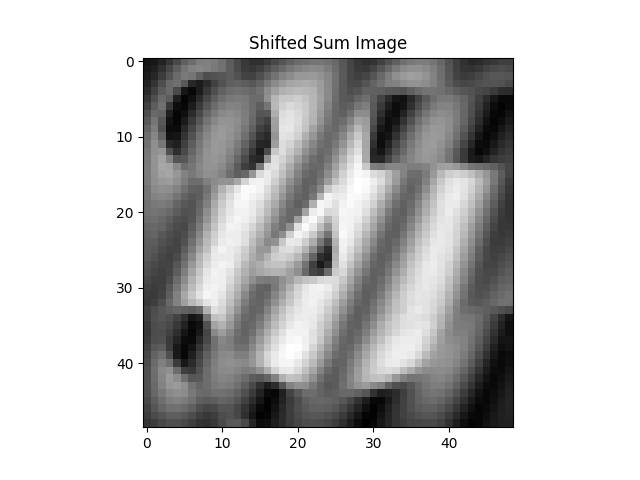

In [12]:
plt.figure()
plt.title("Shifted Sum Image")
plt.imshow(res["shifted_sum"].data, cmap="gray")

## 4 - Descan error fit

With the scan_step parameters determined and more certainty on the input coordinate scan coordinates, we can then solve simultaneously on the three datasets to determine the descan error matrix that describes the microscope experiment. This descan error matrix will determine the propagation matrix of the microscope that describes the descan error dependance on camera length.

In [13]:

descan_error_params_fit = fit_descan_error_matrix(guess_params, com_r)
guess_params['descan_error'] = descan_error_params_fit

print("Fitted versus Known descan error parameters:")
print(f"{'Parameter':20s}{'Fitted Value':25s}{'Known Value':25s}")
print("-" * 70)
for key in descan_error_params_fit._fields:
    fitted_val = getattr(descan_error_params_fit, key)
    known_val = getattr(descan_error, key)
    print(f"{key:20s}{f'{fitted_val:+.3f}':25s}{f'{known_val:+.3f}':25s}")

Fitted versus Known descan error parameters:
Parameter           Fitted Value             Known Value              
----------------------------------------------------------------------
pxo_pxi             +20301.343               +19923.432               
pxo_pyi             +28269.208               +28127.260               
pyo_pxi             +36326.321               +36081.006               
pyo_pyi             -26975.039               -27016.383               
sxo_pxi             +22795.940               +23358.918               
sxo_pyi             +18196.971               +18275.144               
syo_pxi             +21661.381               +21813.585               
syo_pyi             +7179.221                +7761.258                
offpxi              +0.000                   +0.000                   
offpyi              -0.000                   +0.000                   
offsxi              -0.000                   +0.000                   
offsyi              +0.000      

## Show final result

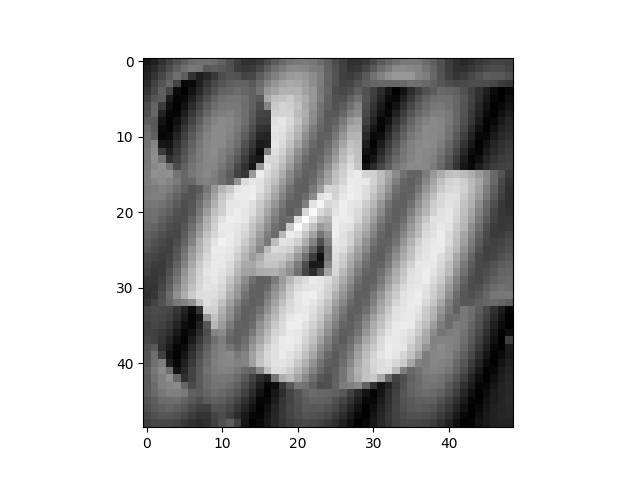

In [14]:
udf = ShiftedSumUDF(
    model_parameters=guess_params
)
res = ctx.run_udf(datasets[cl], udf, progress=False)

plt.figure()
plt.imshow(res["shifted_sum"].data, cmap="gray")